# Goal
- Analyze the bias variance tradeoff of the dataset
- We adopt the setting from Cuarana 2009

In [1]:
import os
os.chdir('../')
import sys
sys.path.insert(0, './my_interpret/python')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, ShuffleSplit
import seaborn as sns
from sklearn.metrics import roc_auc_score
import loaddata_utils
import pickle
from general_utils import vector_in

In [4]:
def cal_statistics(table, metric, is_metric_higher_better):
    # Add two rows
    mean_score = table.apply(lambda x: x.apply(lambda s: float(s[:s.index(' +-')] if isinstance(s, str) and ' +-' in s else s)).mean(), axis=0)
    new_table = add_new_row(table, mean_score.apply(lambda x: '%.4f' % x), 'average')
    
    average_rank = mean_score.rank(ascending=(not is_metric_higher_better))
    new_table = add_new_row(new_table, average_rank, 'average_rank')

    mean_rank = table.apply(rank, axis=1, is_metric_higher_better=is_metric_higher_better).mean()
    new_table = add_new_row(new_table, mean_rank.apply(lambda x: '%.2f' % x), 'avg_rank')
    
    avg_rank_rank = mean_rank.rank(ascending=True)
    new_table = add_new_row(new_table, avg_rank_rank, 'avg_rank_rank')

    mean_normalized_score = table.apply(normalized_score, axis=1, is_metric_higher_better=is_metric_higher_better).mean()
    new_table = add_new_row(new_table, mean_normalized_score.apply(lambda x: '%.3f' % x), 'avg_score')
    
    avg_score_rank = mean_normalized_score.rank(ascending=False)
    new_table = add_new_row(new_table, avg_score_rank, 'avg_score_rank')
    
    if 'auc' in metric:
        mean_normalized_score_b = table.apply(normalized_score, axis=1, min_value=0.5, is_metric_higher_better=is_metric_higher_better).mean()
        new_table = add_new_row(new_table, mean_normalized_score_b.apply(lambda x: '%.3f' % x), 'avg_score_b0.5')

        avg_score_rank_b = mean_normalized_score_b.rank(ascending=False)
        new_table = add_new_row(new_table, avg_score_rank_b, 'avg_score_b0.5_rank')

    return new_table

## Add experiment

### Logloss curve

In [14]:
all_record_df = pd.read_csv('./results/0210_add-fimp-AddExp-091719_datasets.tsv', sep='\t', converters={
    k: pd.eval for k in ['test_test_feat_idxes', 'test_test_feat_perf', 'test_test_feat_names']
})
all_record_df.tail()

,d_name,model_name,model_path,split_idx,n_splits,test_size,random_state,metric,test_test_initial_perf,test_test_feat_idxes,test_test_feat_perf,test_test_feat_names
1580,support2cls2,ebm-bf-o100-i100-q,models/091719_datasets/support2cls2_ebm-bf-o10...,0,5,0.150,1377,logloss,0.576,"[3, 4, 25, 23, 9, 21, 0, 14, 10, 11, 8, 7, 28,...","[0.5225338329541973, 0.5039270159658622, 0.487...","[scoma, hday, dzclass, adlsc, hrt, adlp, age, ..."
1581,support2cls2,ebm-bf-o100-i100-q,models/091719_datasets/support2cls2_ebm-bf-o10...,1,5,0.150,1377,logloss,0.557,"[3, 25, 4, 23, 14, 21, 9, 15, 7, 12, 19, 10, 2...","[0.5023056925302695, 0.4794490974724434, 0.472...","[scoma, dzclass, hday, adlsc, bili, adlp, hrt,..."
1582,support2cls2,ebm-bf-o100-i100-q,models/091719_datasets/support2cls2_ebm-bf-o10...,2,5,0.150,1377,logloss,0.598,"[3, 25, 4, 21, 23, 9, 7, 12, 15, 28, 11, 0, 10...","[0.549091837222499, 0.5162663719763759, 0.4955...","[scoma, dzclass, hday, adlp, adlsc, hrt, meanb..."
1583,support2cls2,ebm-bf-o100-i100-q,models/091719_datasets/support2cls2_ebm-bf-o10...,3,5,0.150,1377,logloss,0.583,"[3, 4, 25, 21, 7, 23, 14, 19, 10, 9, 13, 2, 28...","[0.5270046117419371, 0.5025226702690222, 0.480...","[scoma, hday, dzclass, adlp, meanbp, adlsc, bi..."
1584,support2cls2,ebm-bf-o100-i100-q,models/091719_datasets/support2cls2_ebm-bf-o10...,4,5,0.150,1377,logloss,0.555,"[3, 4, 25, 14, 21, 7, 23, 0, 19, 12, 11, 8, 10...","[0.506286502697883, 0.4797753081993127, 0.4611...","[scoma, hday, dzclass, bili, adlp, meanbp, adl..."


In [15]:
logloss_record_df = all_record_df[all_record_df.metric == 'logloss']
logloss_record_df.head()

,d_name,model_name,model_path,split_idx,n_splits,test_size,random_state,metric,test_test_initial_perf,test_test_feat_idxes,test_test_feat_perf,test_test_feat_names
0,adult,ebm-bf-o50-q,models/091719_datasets/adult_ebm-bf-o50-q_r137...,0,5,0.150,1377,logloss,0.655,"[10, 3, 0, 2, 4, 9, 5, 8, 12, 6, 1, 13, 7, 11]","[0.5084845569799945, 0.4452621785853167, 0.395...","[Relationship, CapitalGain, Age, EducationNum,..."
1,adult,flam,models/091719_datasets/adult_flam_r1377_0_10.pkl,0,10,0.150,1377,logloss,0.633,"[8, 3, 2, 0, 4, 9, 5, 6, 10, 12, 1, 13, 7, 11]","[0.47184657264226343, 0.42025880521645653, 0.3...","[MaritalStatus, CapitalGain, EducationNum, Age..."
2,adult,ilr-q,models/091719_datasets/adult_ilr-q_r1377_0_5.pkl,0,5,0.150,1377,logloss,0.726,"[8, 3, 0, 9, 4, 7, 2, 5, 6, 13, 11, 10, 12, 1]","[0.5078720073636961, 0.4489777190944498, 0.381...","[MaritalStatus, CapitalGain, Age, Occupation, ..."
3,adult,lr,models/091719_datasets/adult_lr_r1377_0_10.pkl,0,10,0.150,1377,logloss,0.640,"[8, 3, 9, 7, 5, 2, 4, 0, 10, 12, 6, 1, 11, 13]","[0.47490884968908764, 0.4450443695103547, 0.40...","[MaritalStatus, CapitalGain, Occupation, Educa..."
4,adult,lr-l1,models/091719_datasets/adult_lr-l1_r1377_0_5.pkl,0,5,0.150,1377,logloss,0.634,"[8, 2, 3, 9, 5, 0, 4, 10, 12, 6, 1, 7, 13, 11]","[0.4782732968973819, 0.4140299434164022, 0.392...","[MaritalStatus, EducationNum, CapitalGain, Occ..."


In [16]:
def my_normalize(x, data_mode='test_test'):
    one_side = x['%s_initial_perf' % data_mode]
    the_other_side = x['%s_feat_perf' % data_mode][-1]
    
#     assert one_side >= the_other_side
    if (one_side < the_other_side):
        print('Not stable for %s %s %d' % (x['d_name'], x['model_name'], x.split_idx))
    
    largest = one_side
    lowest = the_other_side
    
#     largest = max(one_side, the_other_side)
#     lowest = min(one_side, the_other_side)
    
    result = np.array([one_side] + x['%s_feat_perf' % data_mode])
    result = (result - lowest) / (largest - lowest)
    return result.tolist()

logloss_record_df['test_test_feat_perf_rel'] = logloss_record_df.apply(my_normalize, data_mode='test_test', axis=1)

Not stable for heart mlr-q 1
Not stable for heart mlr-q 3
Not stable for heart mlr-q 4
Not stable for churn xgb-l-d3-o20-cols0.5 2


/h/kingsley/anaconda3/envs/gam/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [17]:
def the_mean(x):
    return np.vstack(x).mean(axis=0).tolist()
def the_std(x):
    return np.vstack(x).std(axis=0).tolist()

logloss_summary_df = logloss_record_df.groupby(['d_name', 'model_name'])[['test_test_feat_perf_rel']].agg([the_mean, the_std]).reset_index()
logloss_summary_df.head()

d_name          model_name  \
                               
0  adult  ebm-bf-o100-i100-q   
1  adult        ebm-bf-o50-q   
2  adult      ebm-h-bf-o50-q   
3  adult     ebm-h-o50-i50-q   
4  adult     ebm-o100-i100-q   

                             test_test_feat_perf_rel  \
                                            the_mean   
0  [1.0, 0.595902561091431, 0.3924453091181096, 0...   
1  [1.0, 0.6346958643303859, 0.4342371172945715, ...   
2  [1.0, 0.588166496941146, 0.3914959198798905, 0...   
3  [1.0, 0.6271776376709839, 0.4338177286280839, ...   
4  [1.0, 0.6539385994098306, 0.4529413050840533, ...   

                                                      
                                             the_std  
0  [0.0, 0.019509176330361196, 0.0109873667698967...  
1  [0.0, 0.01871225431523646, 0.00770821546368364...  
2  [0.0, 0.015629283200886412, 0.0111667751474616...  
3  [0.0, 0.010028434763355038, 0.0191701411741255...  
4  [0.0, 0.016552083895819997, 0.0202125170927446...

In [18]:
logloss_summary_df.d_name.unique()

array(['adult', 'breast', 'churn', 'compass', 'credit', 'heart',
       'mimicii', 'mimiciii', 'pneumonia', 'support2cls2'], dtype=object)

In [19]:
logloss_summary_df.model_name.unique()

array(['ebm-bf-o100-i100-q', 'ebm-bf-o50-q', 'ebm-h-bf-o50-q',
       'ebm-h-o50-i50-q', 'ebm-o100-i100-q', 'ebm-o50-i50-q', 'flam',
       'ilr-q', 'lr', 'lr-l1', 'mlr-q', 'spline-v2', 'xgb-d1',
       'xgb-d1-o100', 'xgb-d1-o20-cols0.00001', 'xgb-d1-o20-cols1',
       'xgb-l-d1-o20-cols0.00001', 'xgb-l-d1-o20-cols0.1',
       'xgb-l-d1-o20-cols0.5', 'xgb-l-d1-o20-cols1', 'xgb-l-d3-cols0.5',
       'xgb-l-d3-o20-cols0.5', 'xgb-d1-o20-cv', 'xgb-d1-o20-cols0.5'],
      dtype=object)

#### Area Under the curve

In [20]:
# def cal_area_till_zero(x):
#     # find the first one that's smaller than 0
#     assert x[0] == 1., 'wierd x[0]: ' + str(x[0])
#     tmp = np.arange(len(x))[np.array(x) < 0]
#     if len(tmp) == 0:
#         return np.trapz(x, dx=(1. / (len(x) - 1)))
    
#     # calculate the intercept of the point of 0
#     assert x[tmp[0] - 1] >= 0. and x[tmp[0]] < 0, 'wierd x: ' + str(x[tmp[0]-1]) + ' ' + str(x[tmp[0]])
#     intercept = x[tmp[0]-1] / (x[tmp[0]-1] - x[tmp[0]])
    
#     the_coord = np.array(list(range(tmp[0])) + [tmp[0] - 1 + intercept]) / (len(x) - 1)
# #     print(the_coord)
#     return np.trapz(x[:tmp[0]] + [0.], the_coord)

# # logloss_summary_df['area_under_curve'] = logloss_summary_df.test_test_feat_perf_rel.the_mean.apply(cal_area_till_zero)

In [32]:
from vis_utils import rank, normalized_score, add_new_row, highlight_min_max

selected_model_names = [
    'ebm-bf-o100-i100-q', 'ebm-o100-i100-q', 
    'flam',  'lr', 'lr-l1',
#     'mlr-q', 
#     'ilr-q',
    'spline-v2', 
#     'xgb-d1-o20-cv',
#     'xgb-l-d1-o20-cols0.5', 
    'xgb-l-d1-o20-cols0.00001', 
#     'xgb-l-d1-o20-cols0.1', 'xgb-l-d1-o20-cols1',
    'xgb-l-d1-o20-cols1',
    'xgb-d1-o100', 
    'xgb-d1-o20-cols0.00001', 
]

selected_datasets = [
    'adult', 'churn', 
    'breast', 'compass', 'credit', 'heart', 
    'mimicii', 'mimiciii', 'pneumonia', 'support2cls2'
]

# tmp = logloss_summary_df[vector_in(logloss_summary_df.model_name, ['ebm', 'ebm-bf', 'xgb-d1', 'skgbt', 'ilr', 'lr', 'mlr', 'spline'])]
tmp = logloss_summary_df
tmp = tmp[vector_in(tmp.d_name, selected_datasets)]
tmp = tmp[vector_in(tmp.model_name, selected_model_names)]

last_indexes = tmp.groupby('d_name').apply(lambda x: x['test_test_feat_perf_rel']['the_mean'].apply(lambda x: np.arange(len(x))[np.array(x) < 0]).apply(lambda x: 100000 if len(x) == 0 else x[0]).min())

In [33]:
last_indexes['compass']

100000

In [34]:
def cal_area_till_zero(row):
    the_last = last_indexes[row.d_name].values[0]
    x = row.test_test_feat_perf_rel.the_mean
    
    x = x[:the_last]

    # find the first one that's smaller than 0
    assert x[0] == 1., 'wierd x[0]: ' + str(x[0])
    tmp = np.arange(len(x))[np.array(x) < 0]
    if len(tmp) == 0:
        return np.trapz(x, dx=(1. / (len(x) - 1)))
    print('Impossible!!!!')

In [35]:
tmp['area_under_curve'] = tmp.apply(cal_area_till_zero, axis=1)

In [37]:
table = pd.pivot_table(tmp[['d_name', 'model_name', 'area_under_curve']], index='d_name', columns=['model_name'])['area_under_curve']['']

table['xgb-d1-o100'] = table.apply(lambda row: row['xgb-l-d1-o20-cols1'] if pd.isna(row['xgb-d1-o100']) else row['xgb-d1-o100'], axis=1)
table['xgb-d1-o20-cols0.00001'] = table.apply(lambda row: row['xgb-l-d1-o20-cols0.00001'] if pd.isna(row['xgb-d1-o20-cols0.00001']) else row['xgb-d1-o20-cols0.00001'], axis=1)
table = table.drop(['xgb-l-d1-o20-cols0.00001'], axis=1)

table = cal_statistics(table, '', is_metric_higher_better=True)

pd.options.display.float_format = '{:,.3f}'.format
display(table.style.apply(highlight_min_max, axis=1))

/h/kingsley/anaconda3/envs/gam/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  """Entry point for launching an IPython kernel.


model_name,ebm-bf-o100-i100-q,ebm-o100-i100-q,flam,lr,lr-l1,spline-v2,xgb-d1-o100,xgb-d1-o20-cols0.00001,xgb-l-d1-o20-cols1
adult,0.226234,0.271029,0.210628,0.219618,0.212577,0.204656,0.289740,0.339447,0.282682
breast,0.059089,0.086280,0.076558,0.130498,0.066186,0.233905,0.070360,0.112442,nan
churn,0.129565,0.156799,0.131491,0.199272,0.161817,0.227199,0.128556,0.149728,0.116919
compass,0.170497,0.183009,0.171672,0.177385,0.176845,0.172622,0.178734,0.182667,0.178465
credit,0.157627,0.268593,0.169621,0.123610,0.121855,0.190547,0.193875,0.268997,0.193664
heart,0.217662,0.239706,0.215479,0.326214,0.307591,0.154045,0.250495,0.287430,0.201032
mimicii,0.186305,0.204395,0.188407,0.193764,0.193678,0.210224,0.196192,0.204615,0.197506
mimiciii,0.148238,0.207135,0.186257,0.189705,0.186528,0.215640,0.187407,0.212148,0.188312
pneumonia,0.206269,0.297332,0.258321,0.272474,0.258031,0.195389,0.253318,0.299413,0.249691
support2cls2,0.116784,0.123855,0.113622,0.102755,0.102426,0.125528,0.130465,0.114202,0.133851


In [38]:
table.to_csv('./notebooks/figures/add_logloss_all_0515.csv')

Running
- support2cls & diabetes2 for feature removal, and xgb without label encoding

#### Paper graph

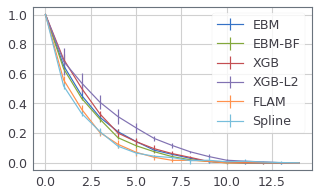

In [448]:
model_names = None
# model_names = ['ebm-o50-i50', 'ebm-bf-o50', 'lr', 'xgb-d1-o20-cv', 'spline-v2', 'rspline-v2', 'rspline-v2-s', 'flam']
# model_names = ['lr', 'lr-l1']
# model_names = table.columns
model_names = ['ebm-o50-i50-q', 'ebm-bf-o50-q', 'xgb-d1-o20-cols1', 'xgb-d1-o20-cols0.00001', 'flam', 'spline-v2']

d_names = ['adult']
# d_names = ['breast']

# d_names = selected_datasets

if d_names is None:
    d_names = logloss_summary_df['d_name'].unique()

for d_name in d_names:
    df = logloss_summary_df[logloss_summary_df.d_name == d_name]
    fig, ax = plt.subplots(figsize=(5, 3))
    
    if model_names is None:
        model_names = df.model_name.unique()
    
    for m_name in model_names:
        df2 = df[df.model_name == m_name]
        if len(df2) == 0:
            continue
        the_mean, the_std = df2.test_test_feat_perf_rel.the_mean.iloc[0], df2.test_test_feat_perf_rel.the_std.iloc[0]
        ax.errorbar(range(len(the_mean)), the_mean, the_std, label=m_name)
    
#     if last_indexes[d_name] < 10000:
#         ax.axvline(last_indexes[d_name], 0, 1)
    
#     ax.set_xlabel('Number of features added')
#     ax.set_ylabel('Relative test MSE')
    ax.legend(['EBM', 'EBM-BF', 'XGB', 'XGB-L2', 'FLAM', 'Spline'])
#     ax.legend()
    ax.set_ylim(-0.05, 1.05)
#     fig.suptitle(d_name, fontsize=30)
    plt.show()

In [449]:
fig.savefig('notebooks/figures/add_logloss_adult.pdf', bbox_inches='tight', dpi=300)

In [331]:
last_indexes[d_name]

4

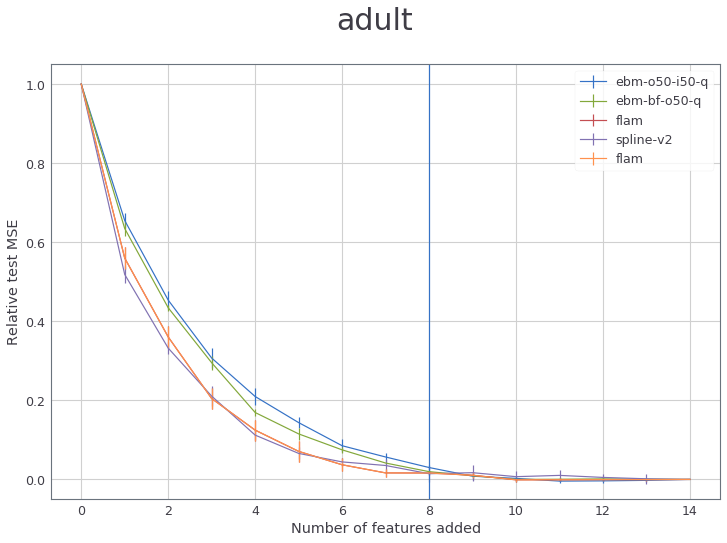

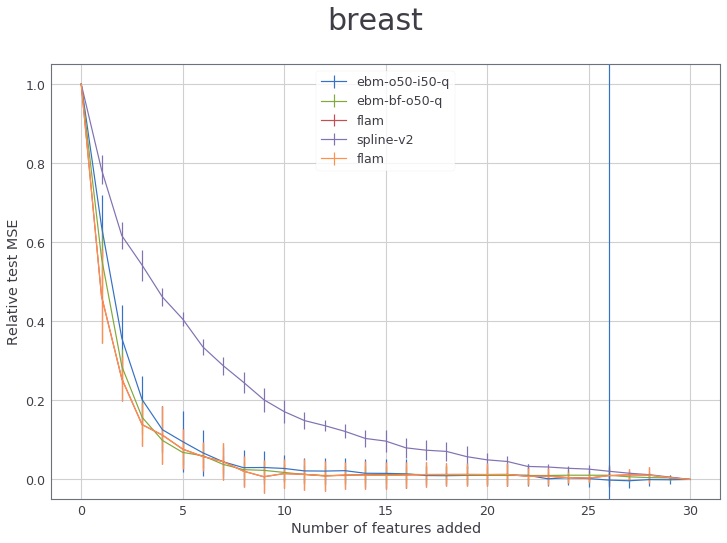

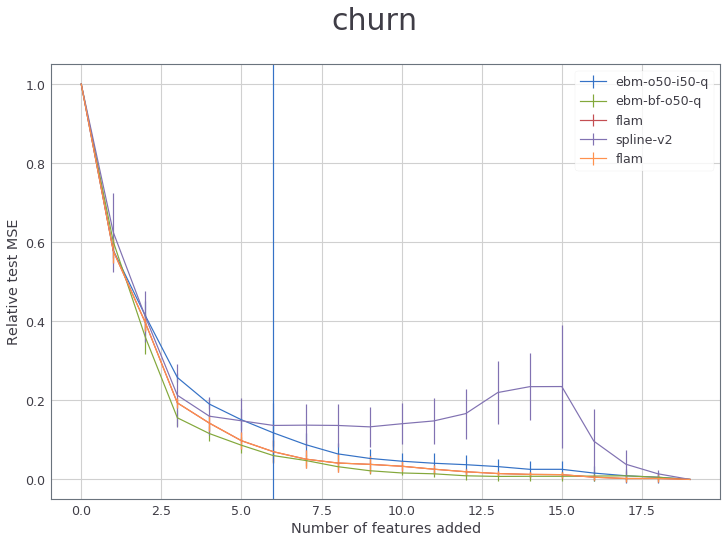

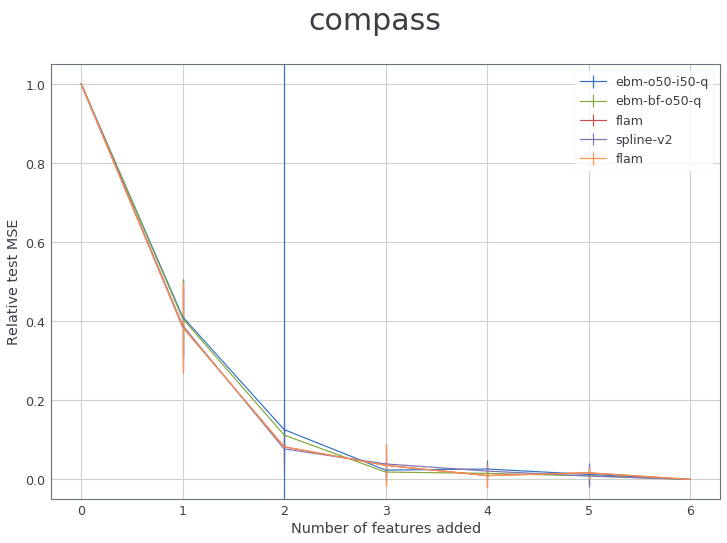

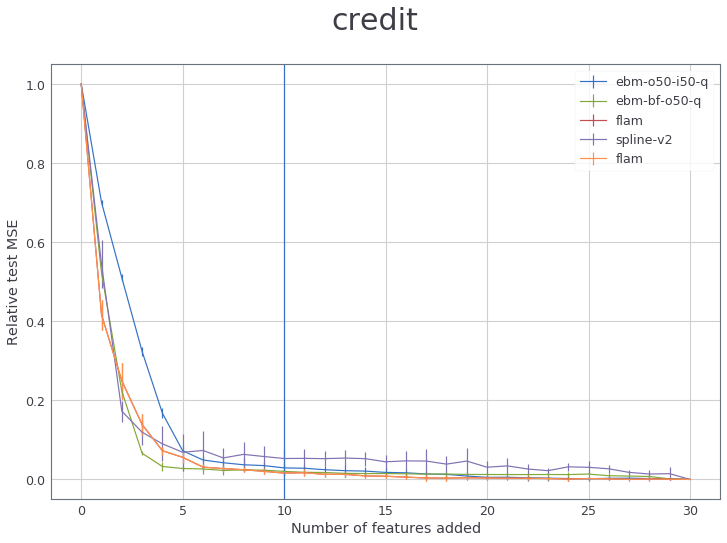

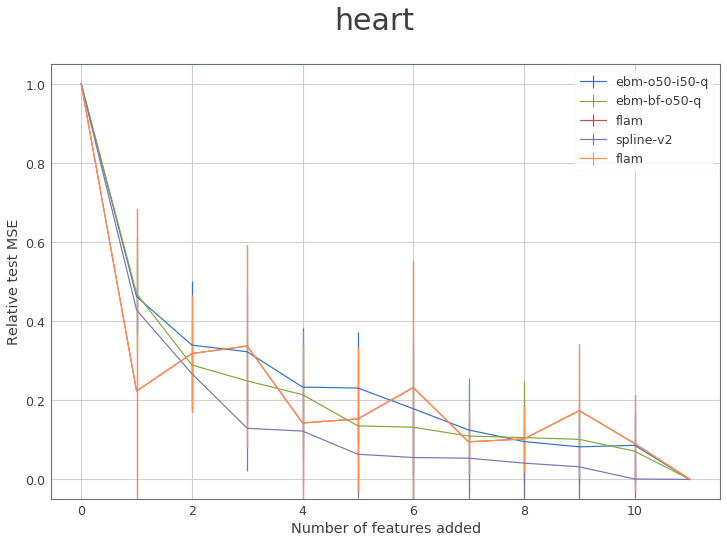

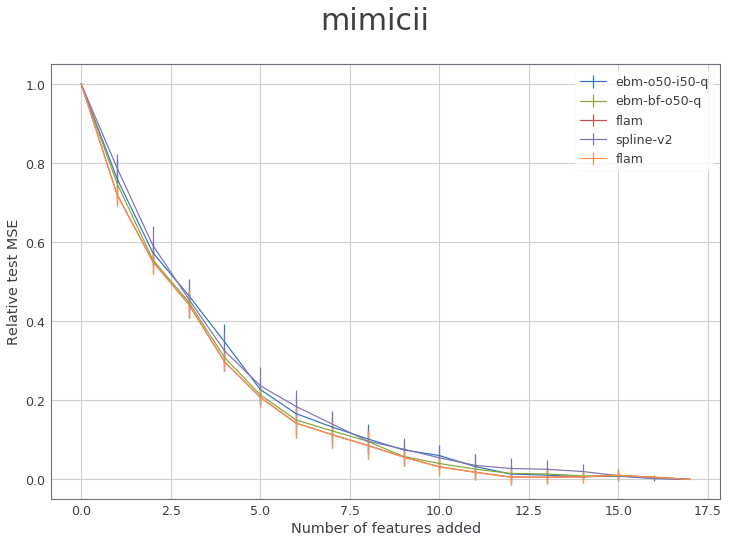

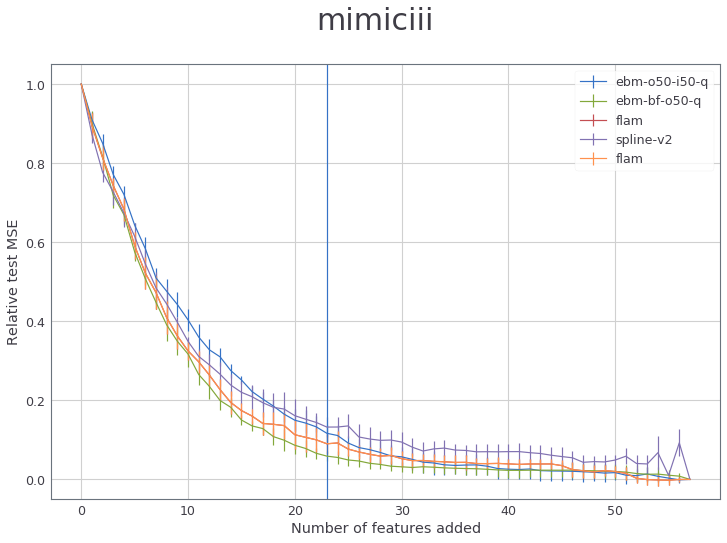

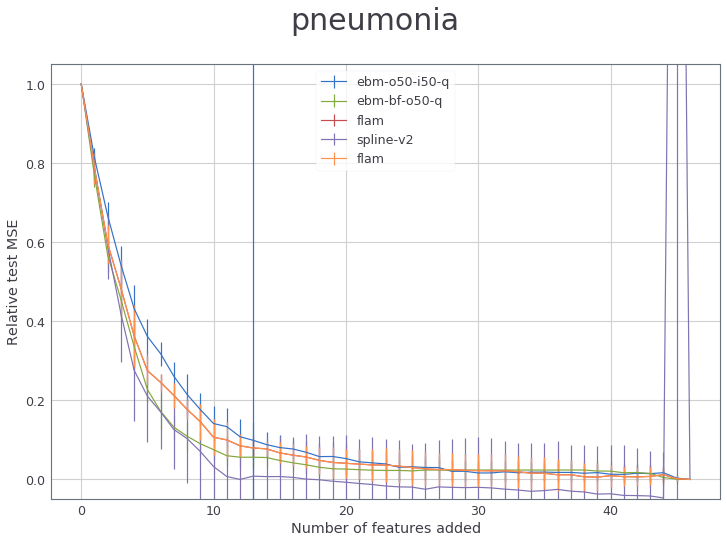

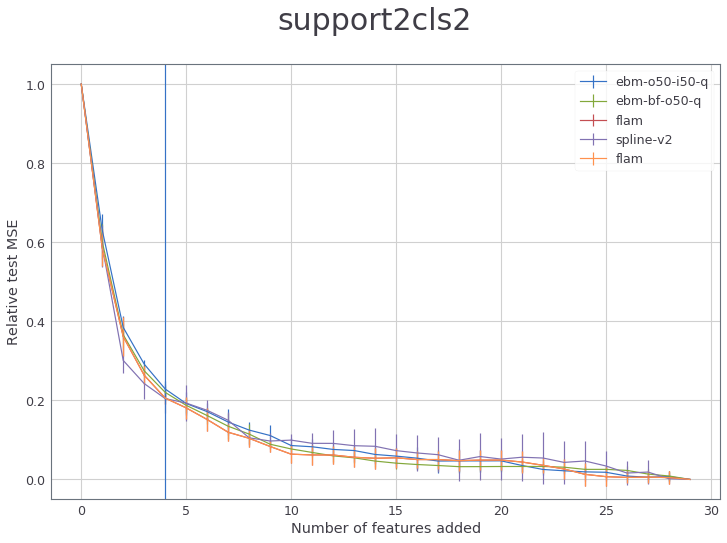

In [334]:
model_names = None
model_names = ['ebm-o50-i50-q', 'ebm-bf-o50-q', 'flam', 'xgb-d', 'spline-v2', 'rspline-v2', 'rspline-v2-s', 'flam']
# model_names = ['lr', 'lr-l1']

d_names = None
# d_names = ['pneumonia', 'mimiciii']

if d_names is None:
    d_names = logloss_summary_df['d_name'].unique()

for d_name in d_names:
    df = logloss_summary_df[logloss_summary_df.d_name == d_name]
    fig, ax = plt.subplots(figsize=(12, 8))
    
    if model_names is None:
        model_names = df.model_name.unique()
    
    for m_name in model_names:
        df2 = df[df.model_name == m_name]
        if len(df2) == 0:
            continue
        the_mean, the_std = df2.test_test_feat_perf_rel.the_mean.iloc[0], df2.test_test_feat_perf_rel.the_std.iloc[0]
        ax.errorbar(range(len(the_mean)), the_mean, the_std, label=m_name)
    
    if last_indexes[d_name] < 10000:
        ax.axvline(last_indexes[d_name], 0, 1)
    
    ax.set_xlabel('Number of features added')
    ax.set_ylabel('Relative test MSE')
    ax.legend()
    ax.set_ylim(-0.05, 1.05)
    fig.suptitle(d_name, fontsize=30)
    plt.show()

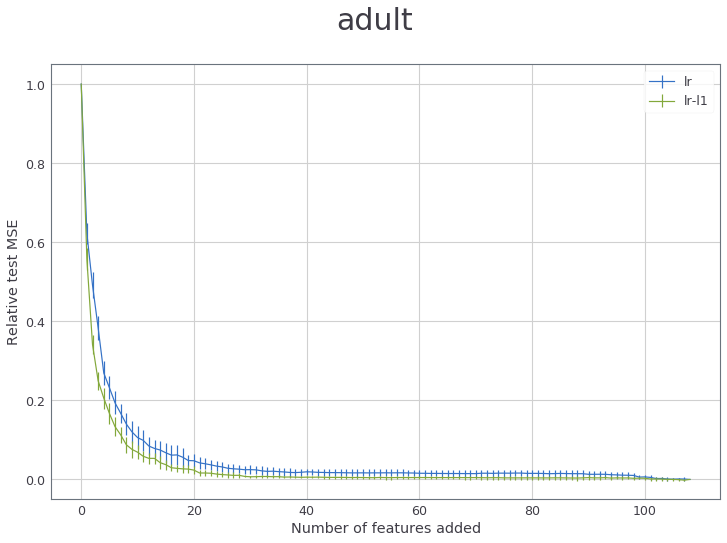

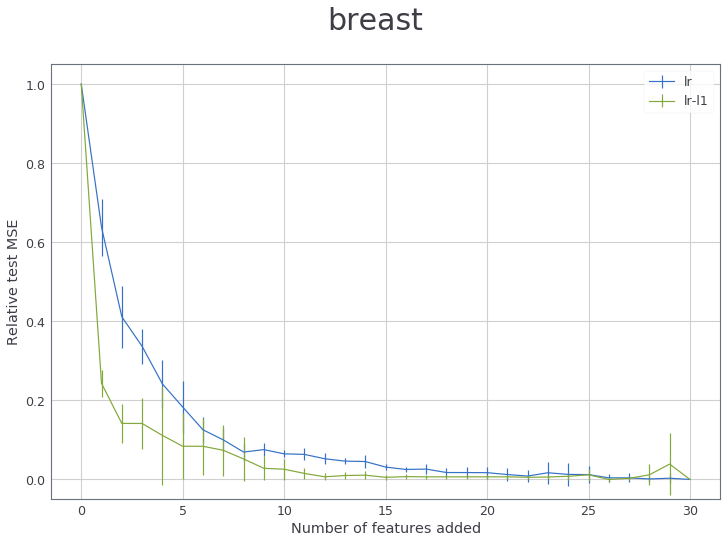

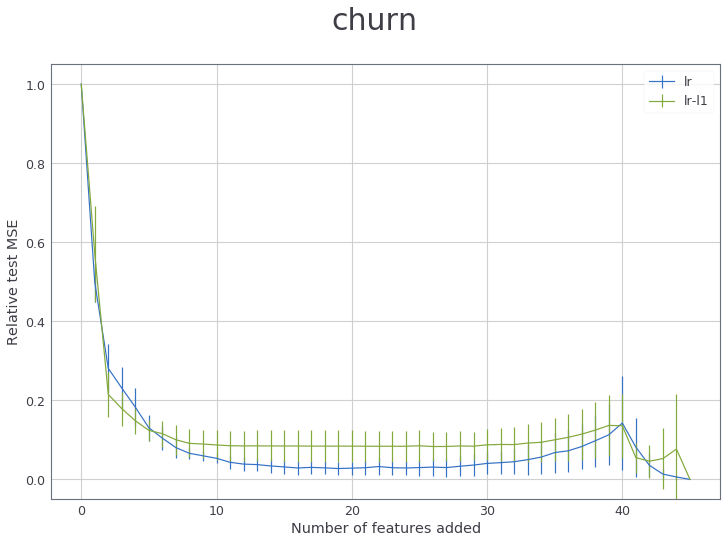

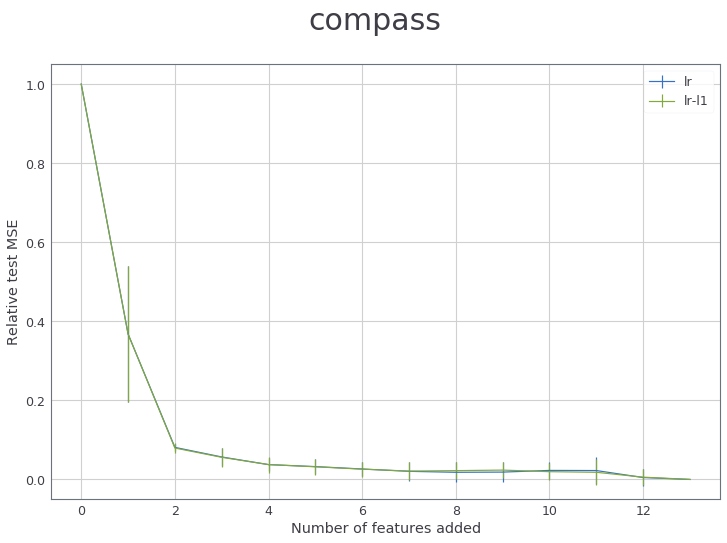

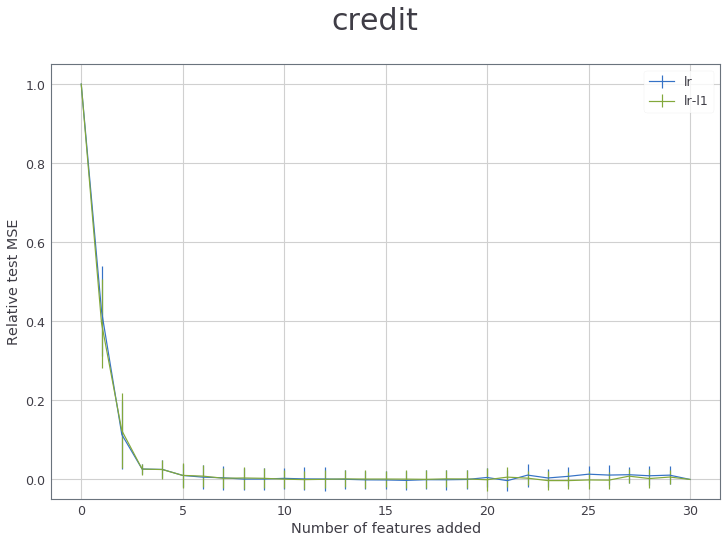

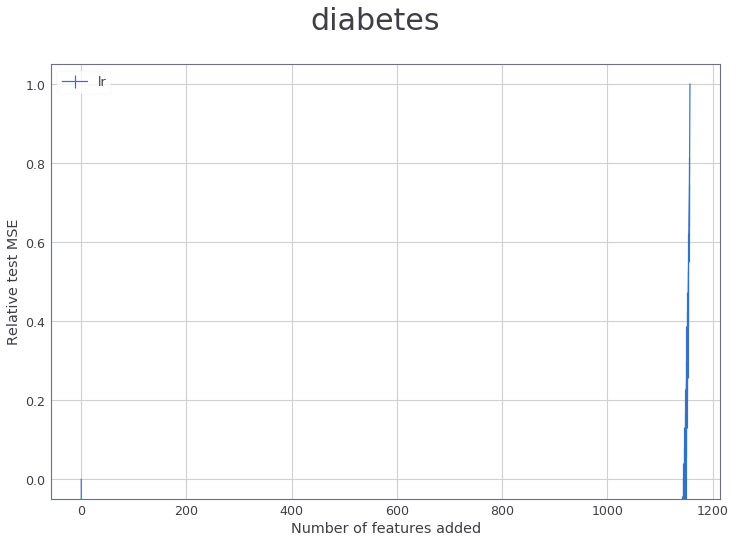

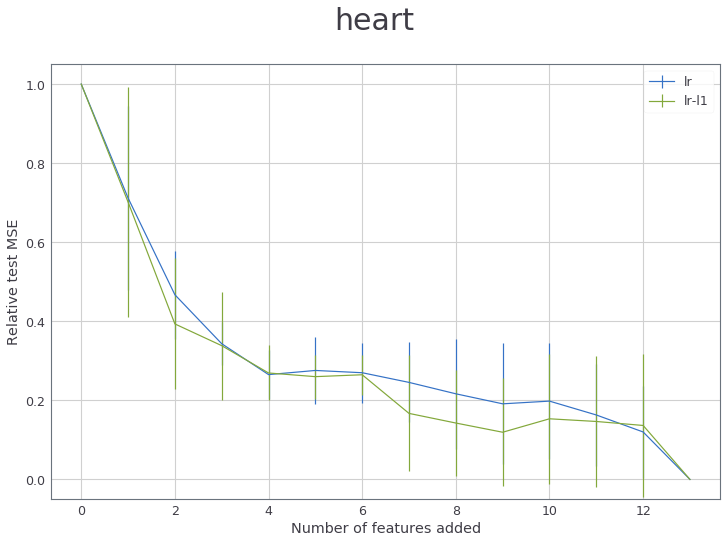

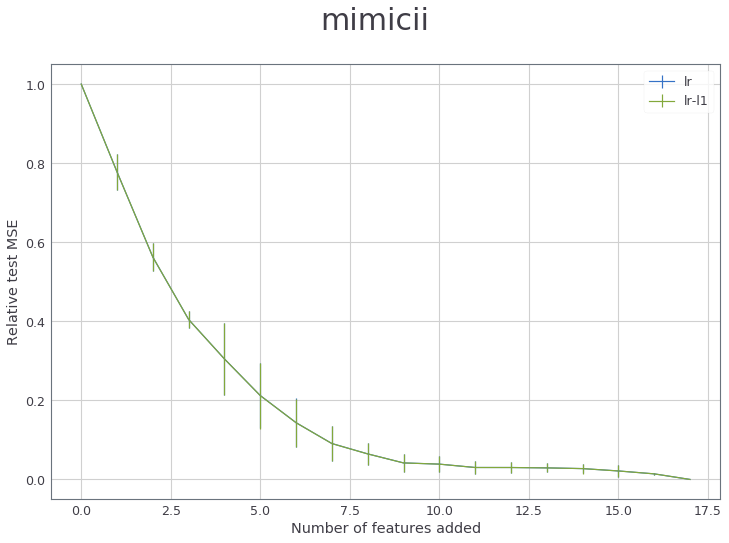

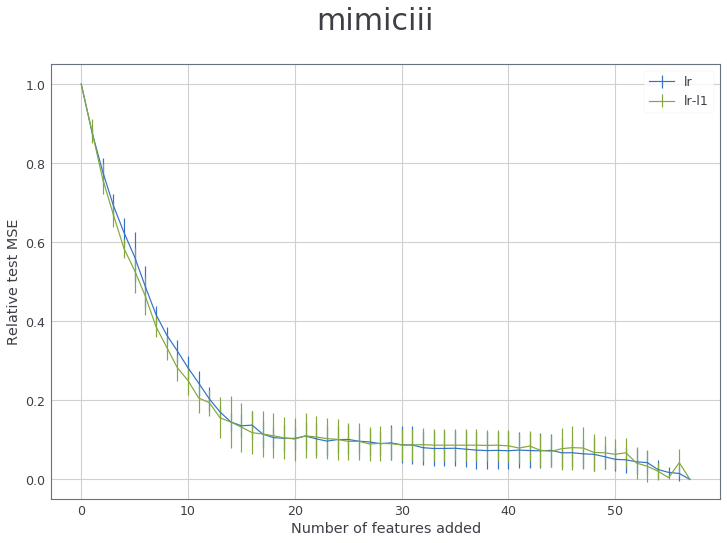

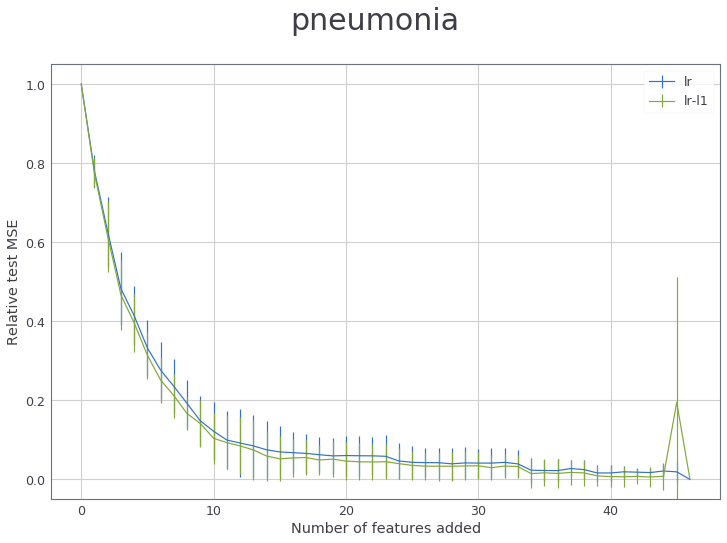

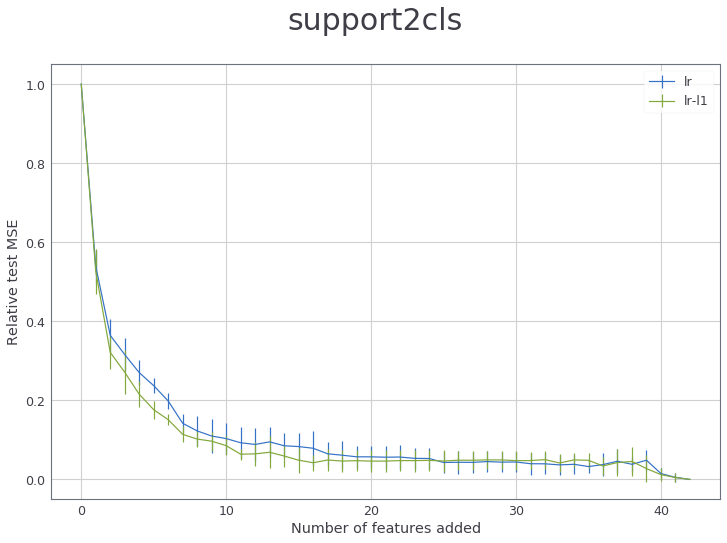

In [123]:
# model_names = None
# model_names = ['ebm-o50-i50', 'ebm-bf-o50', 'lr', 'xgb-d1-o20-cv', 'spline-v2', 'rspline-v2', 'rspline-v2-s', 'flam']
model_names = ['lr', 'lr-l1']

d_names = None
# d_names = ['pneumonia', 'mimiciii']

if d_names is None:
    d_names = logloss_summary_df['d_name'].unique()

for d_name in d_names:
    df = logloss_summary_df[logloss_summary_df.d_name == d_name]
    fig, ax = plt.subplots(figsize=(12, 8))
    
    if model_names is None:
        model_names = df.model_name.unique()
    
    for m_name in model_names:
        df2 = df[df.model_name == m_name]
        if len(df2) == 0:
            continue
        the_mean, the_std = df2.test_test_feat_perf_rel.the_mean.iloc[0], df2.test_test_feat_perf_rel.the_std.iloc[0]
        ax.errorbar(range(len(the_mean)), the_mean, the_std, label=m_name)
    
    ax.set_xlabel('Number of features added')
    ax.set_ylabel('Relative test MSE')
    ax.legend()
    ax.set_ylim(-0.05, 1.05)
    fig.suptitle(d_name, fontsize=30)
    plt.show()

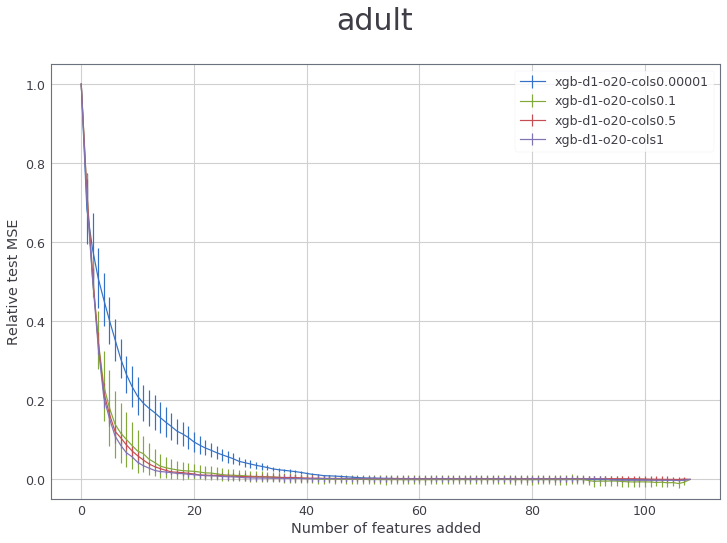

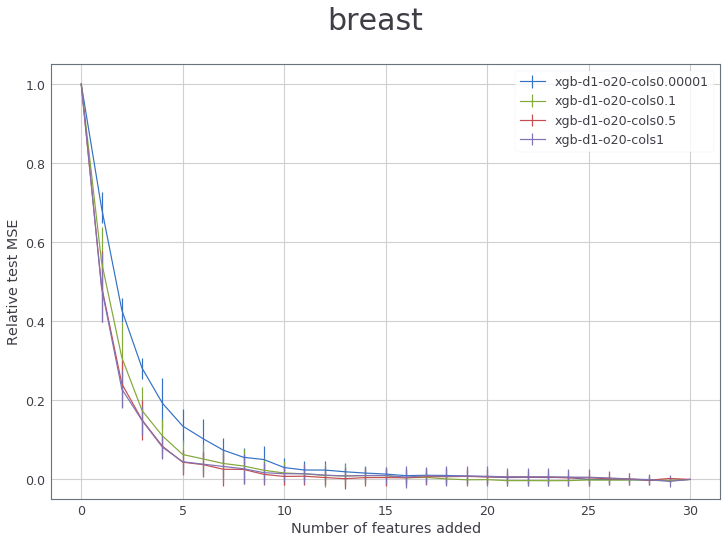

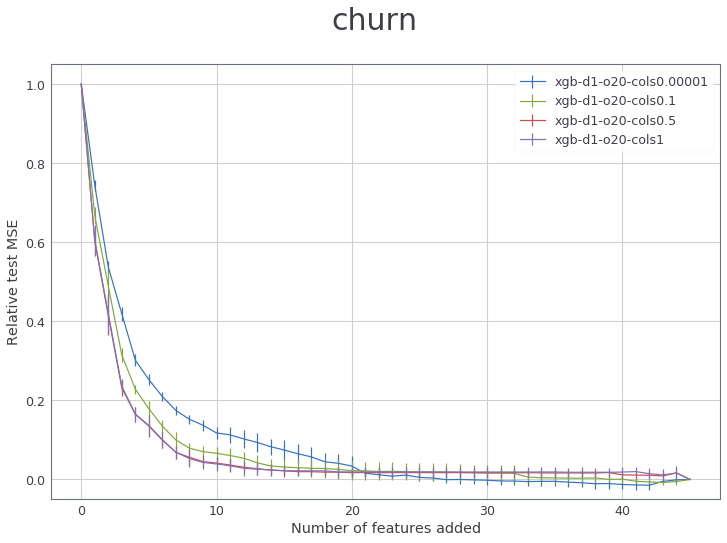

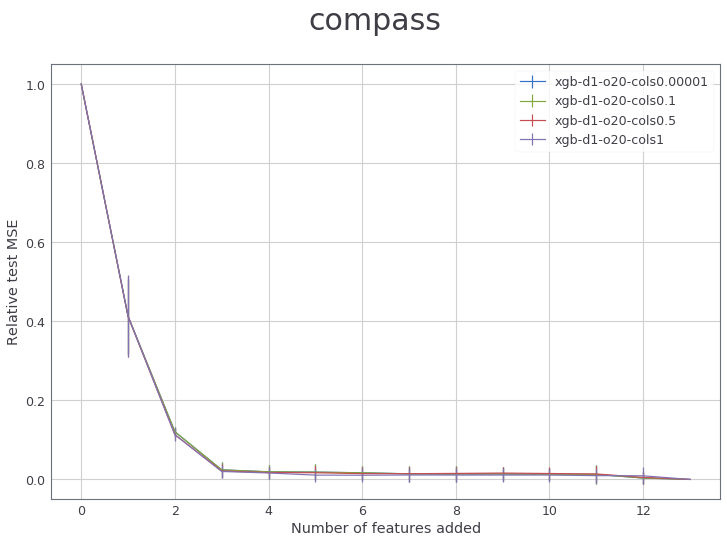

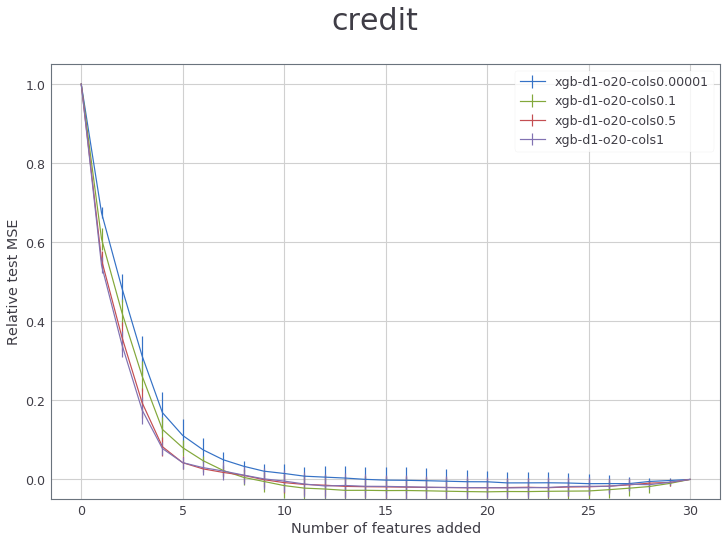

No handles with labels found to put in legend.


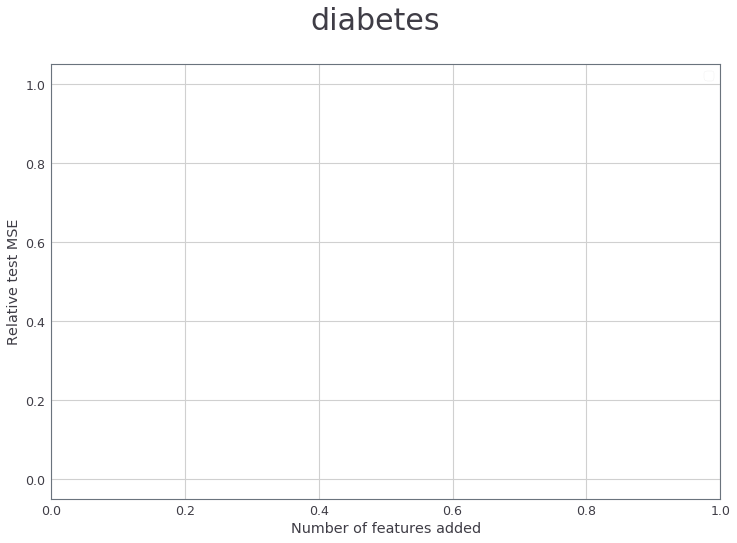

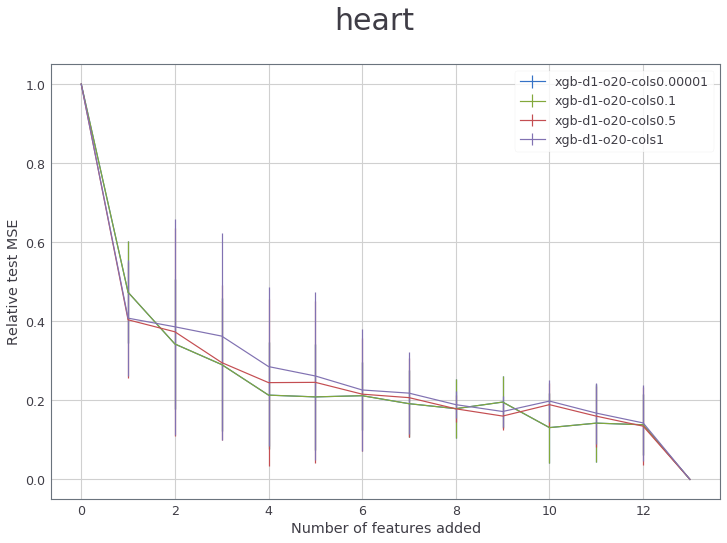

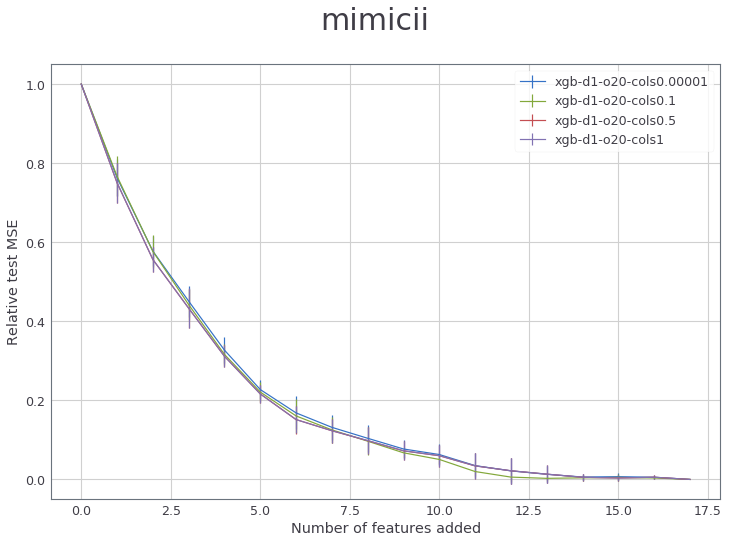

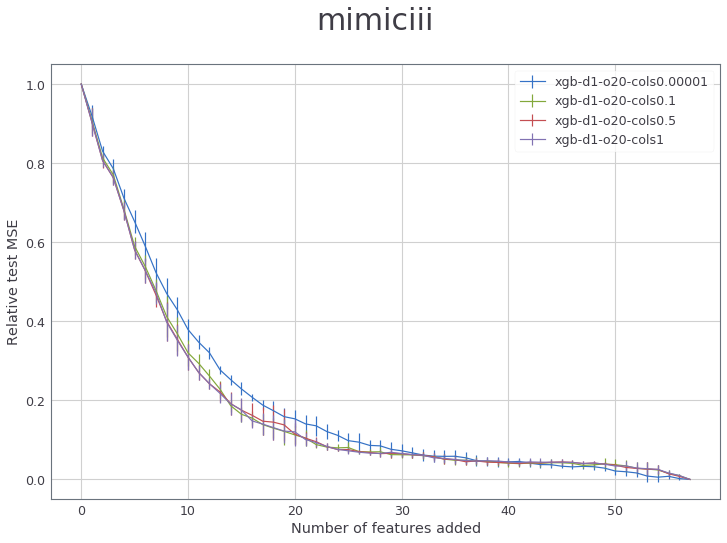

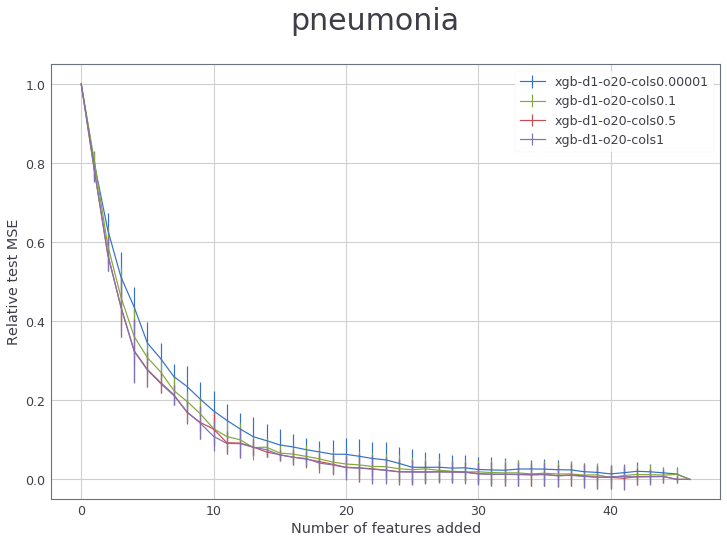

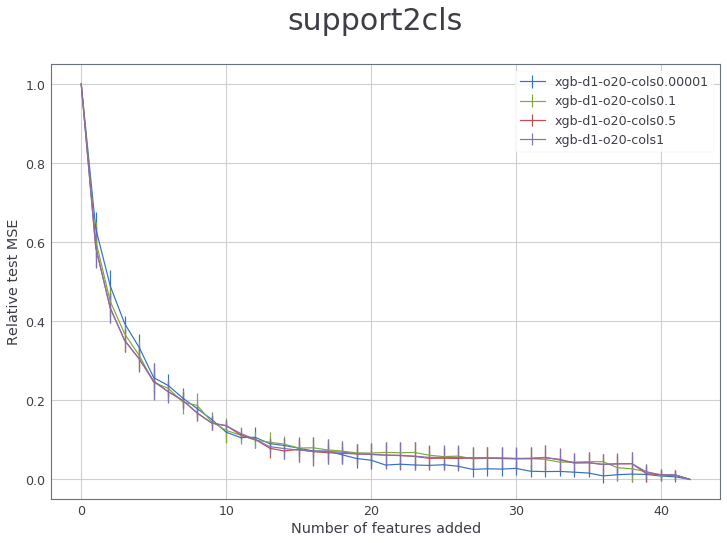

In [125]:
# model_names = None
# model_names = ['ebm-o50-i50', 'ebm-bf-o50', 'lr', 'xgb-d1-o20-cv', 'spline-v2', 'rspline-v2', 'rspline-v2-s', 'flam']
model_names = ['xgb-d1-o20-cols0.00001', 'xgb-d1-o20-cols0.1', 'xgb-d1-o20-cols0.5', 'xgb-d1-o20-cols1']

d_names = None
# d_names = ['pneumonia', 'mimiciii']

if d_names is None:
    d_names = logloss_summary_df['d_name'].unique()

for d_name in d_names:
    df = logloss_summary_df[logloss_summary_df.d_name == d_name]
    fig, ax = plt.subplots(figsize=(12, 8))
    
    if model_names is None:
        model_names = df.model_name.unique()
    
    for m_name in model_names:
        df2 = df[df.model_name == m_name]
        if len(df2) == 0:
            continue
        the_mean, the_std = df2.test_test_feat_perf_rel.the_mean.iloc[0], df2.test_test_feat_perf_rel.the_std.iloc[0]
        ax.errorbar(range(len(the_mean)), the_mean, the_std, label=m_name)
    
    ax.set_xlabel('Number of features added')
    ax.set_ylabel('Relative test MSE')
    ax.legend()
    ax.set_ylim(-0.05, 1.05)
    fig.suptitle(d_name, fontsize=30)
    plt.show()

### Binary plot

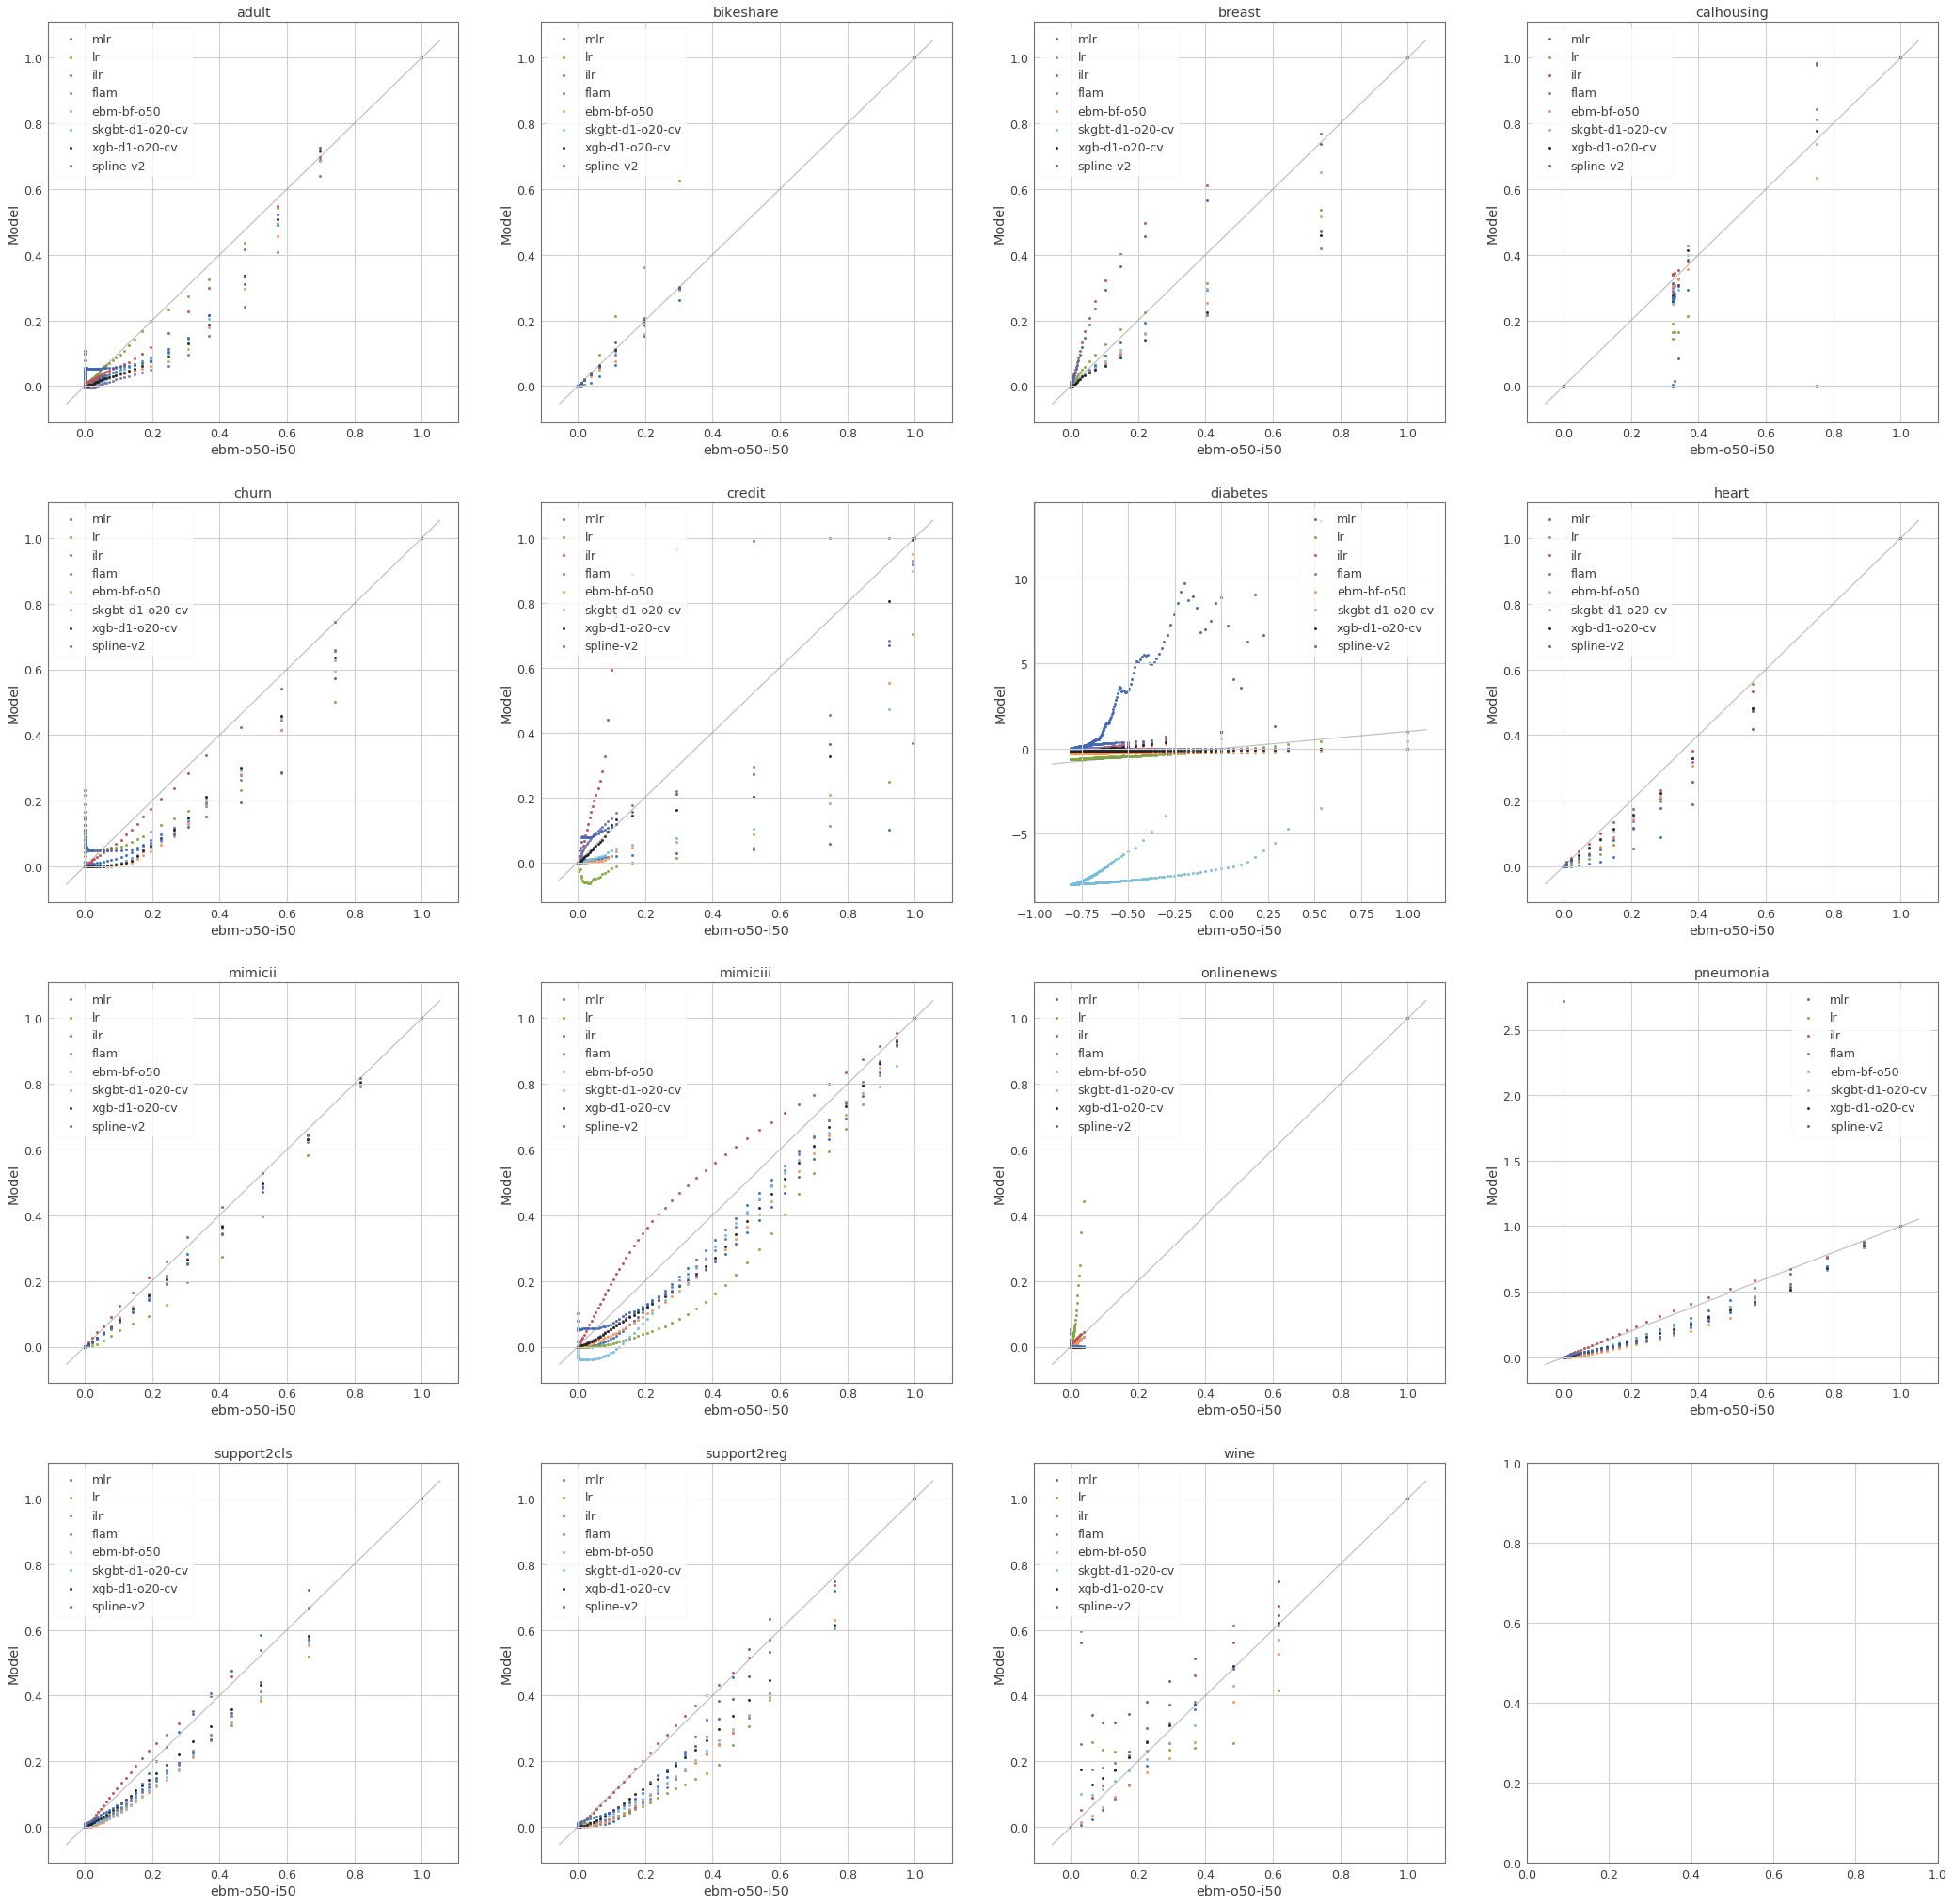

In [85]:
baseline_model = 'ebm-o50-i50'
compared_models = [
    'mlr', 'lr', 'ilr', 'flam', 'ebm-bf-o50', 
    'skgbt-d1-o20-cv', 'xgb-d1-o20-cv', 'spline-v2'
]

num_cols=4
metric = 'train_feat_perf_rel'

tmp_df = mse_record_df[vector_in(mse_record_df.model_name, [baseline_model] + compared_models)]

num_rows = int(np.ceil(len(tmp_df.d_name.unique()) / num_cols))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(9 * num_cols, 9 * num_rows))

fig_idx = 0

for d_name, tmp_df2 in tmp_df.groupby('d_name'):
#     tmp_df2 = tmp_df2.sort_values(['model_name', 'split_idx', 'feature_name'])
    baseline = tmp_df2[tmp_df2.model_name == baseline_model]
    mean_baseline = np.vstack(baseline[metric]).mean(axis=0)
    
    for model_name in compared_models:
        m = tmp_df2[tmp_df2.model_name == model_name]
        mean_model = np.vstack(m[metric]).mean(axis=0)

        axes.flat[fig_idx].scatter(mean_baseline, mean_model, label=model_name, s=8)
    
    axes.flat[fig_idx].set_title(d_name)
    the_limit = axes.flat[fig_idx].get_xlim()
    axes.flat[fig_idx].plot(the_limit, the_limit, '-', color='grey', alpha=0.5)
    axes.flat[fig_idx].legend()
    axes.flat[fig_idx].set_xlabel(baseline_model)
    axes.flat[fig_idx].set_ylabel('Model')
    fig_idx += 1

## Removal experiment

In [36]:
removal_record_df = pd.read_csv('./results/0203_removal-fimp-RemovalExp-091719_datasets.tsv', sep='\t', converters={
    k: pd.eval for k in ['test_test_feat_idxes', 'test_test_feat_perf', 'test_test_feat_names']
})
removal_record_df.tail()

,d_name,model_name,model_path,split_idx,n_splits,test_size,random_state,metric,test_test_initial_perf,test_test_feat_idxes,test_test_feat_perf,test_test_feat_names
346,credit,xgb-d1-o20-cv,models/091719_datasets/credit_xgb-d1-o20-cv_r1...,2,5,0.150,1377,auc,0.988,"[4, 12, 14, 10, 17, 3, 7, 11, 9, 16, 29, 1, 19...","[0.9682835682744355, 0.96861802303912, 0.92166...","[V4, V12, V14, V10, V17, V3, V7, V11, V9, V16,..."
347,credit,xgb-d1-o20-cv,models/091719_datasets/credit_xgb-d1-o20-cv_r1...,3,5,0.150,1377,auc,0.964,"[29, 4, 14, 10, 12, 17, 7, 3, 11, 9, 1, 22, 16...","[0.972027457958803, 0.9705445456711637, 0.9342...","[Amount, V4, V14, V10, V12, V17, V7, V3, V11, ..."
348,credit,xgb-d1-o20-cv,models/091719_datasets/credit_xgb-d1-o20-cv_r1...,4,5,0.150,1377,mse,0.000,"[14, 4, 10, 12, 17, 3, 11, 29, 19, 16, 1, 9, 8...","[0.0010875056943649003, 0.0017012691138137386,...","[V14, V4, V10, V12, V17, V3, V11, Amount, V19,..."
349,credit,xgb-d1-o20-cv,models/091719_datasets/credit_xgb-d1-o20-cv_r1...,4,5,0.150,1377,auc,0.990,"[8, 4, 14, 12, 10, 17, 9, 3, 11, 29, 16, 19, 1...","[0.9917468174198314, 0.960966042055996, 0.9707...","[V8, V4, V14, V12, V10, V17, V9, V3, V11, Amou..."
350,diabetes,mlr,models/091719_datasets/diabetes_mlr_r1377_0_10...,0,10,0.150,1377,mse,0.095,"[8, 7, 964, 944, 954, 946, 0, 5, 3, 264, 958, ...","[0.09703885862905663, 0.09726061030262613, 0.0...","[number_inpatient, number_emergency, discharge..."


### Normalize each split to be 100%

In [37]:
def my_normalize(x, data_mode='train'):
    one_side = x['%s_initial_perf' % data_mode]
    the_other_side = x['%s_feat_perf' % data_mode][-1]
    
    largest = max(one_side, the_other_side)
    lowest = min(one_side, the_other_side)
    
    result = np.array([one_side] + x['%s_feat_perf' % data_mode])
    result = (result - lowest) / (largest - lowest)
    return result.tolist()

removal_record_df['test_test_feat_perf_rel'] = removal_record_df.apply(my_normalize, data_mode='test_test', axis=1)

In [38]:
def the_mean(x):
    return np.vstack(x).mean(axis=0).tolist()
def the_std(x):
    return np.vstack(x).std(axis=0).tolist()

removal_summary_df = removal_record_df.groupby(['d_name', 'model_name'])[['test_test_feat_perf_rel']].agg([the_mean, the_std]).reset_index()
removal_summary_df.head()

d_name   model_name                            test_test_feat_perf_rel  \
                                                                the_mean   
0  adult   ebm-bf-o50  [0.5, 0.538021036635866, 0.5757071332652387, 0...   
1  adult  ebm-o50-i50  [0.5, 0.5308539448022066, 0.5453961924348689, ...   
2  adult         flam  [0.5, 0.5423988558699412, 0.5793651306146356, ...   
3  adult          ilr  [0.5, 0.5261647901208945, 0.54755300316597, 0....   
4  adult           lr  [0.5, 0.5288394317304739, 0.5543152027631267, ...   

                                                      
                                             the_std  
0  [0.5, 0.4032198754424686, 0.2885461523765057, ...  
1  [0.5, 0.39951049214215645, 0.36066043235692447...  
2  [0.5, 0.3671869165927365, 0.25320970551324157,...  
3  [0.5, 0.40368923442259413, 0.33168633775662515...  
4  [0.5, 0.4280734319915165, 0.347434478043184, 0...

### Area under curve

In [42]:
removal_summary_df['area_under_curve'] = removal_summary_df.test_test_feat_perf_rel.the_mean.apply(lambda x: np.trapz(x, dx=(1. / (len(x) - 1))))

In [45]:
from vis_utils import rank, normalized_score, add_new_row, highlight_min_max

tmp = removal_summary_df[vector_in(removal_summary_df.model_name, ['ebm', 'ebm-bf', 'xgb-d1', 'skgbt', 'ilr', 'lr', 'mlr', 'spline'])]
tmp = tmp[~vector_in(tmp.d_name, ['bikeshare', 'calhousing'])]
table = pd.pivot_table(tmp[['d_name', 'model_name', 'area_under_curve']], index='d_name', columns=['model_name'])

mean_score = table.mean(axis=0)
table = add_new_row(table, mean_score, 'average')

pd.options.display.float_format = '{:,.3f}'.format
table.style.apply(highlight_min_max, axis=1)